# Store Sales - Time Series Forecasting

## Table of Contents

**I. Information**<br>
**II. Data cleansing**<br>
**III. Data Analysis**<br> 
&nbsp;&nbsp;*1. Holiday Events*<br>
&nbsp;&nbsp;*2. Oil Prices*<br>
&nbsp;&nbsp;*3. Stores*<br>
&nbsp;&nbsp;*4. Transactions*<br>
&nbsp;&nbsp;*5. Train Dataset*<br>
**IV. Feature Generation**<br>
**V. Preparation of Dataset for Model**<br>
**VI.Model 1<br>
**VII. Model 2<br>
**VIII. Model 3<br>

## I. Information

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

*Link:* https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

**train.csv**
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

**stores.csv**
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

**oil.csv**
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## II. Data Cleansing

#### Import Libraries

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#### Import Dataset

In [121]:
df_holidays_events = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_transactions = pd.read_csv('transactions.csv')

#### Functions

In [122]:
# Converts numerical weekday to day of the week
def convert_to_day(weekday_list):
    list2 = []
    for i in range(len(weekday_list)):
        if weekday_list[i] == 0:
            list2.append('Monday')
        elif weekday_list[i] == 1:
            list2.append('Tuesday')
        elif weekday_list[i] == 2:
            list2.append('Wednesday')
        elif weekday_list[i] == 3:
            list2.append('Thursday')
        elif weekday_list[i] == 4:
            list2.append('Friday')
        elif weekday_list[i] == 5:
            list2.append('Saturday')
        else:
            list2.append('Sunday')
    return list2

#### Oil Dataset

*Work Done*
- The oil dataset comprises of 1236 rows of oil data for various dates
- We have removed the NA values and have 1190 rows of data left
- The NA values corresponded to holidays

In [123]:
# Use the date to convert to day of week
df_oil['day_of_week'] = convert_to_day(list(pd.to_datetime(df_oil['date']).dt.dayofweek))
# merge oil and holiday events dataframe
df_oil = pd.merge(df_oil, df_holidays_events, on = 'date', how = 'outer')
# drop the following columns: 'locale_name', 'description', 'transferred'
df_oil = df_oil.drop(["locale_name","description","transferred", "locale"], axis = 1)
# drop NA values based on the 'day_of_week' column
df_oil = df_oil.dropna(subset = ['day_of_week'])
# drop NA values based on the 'dcoilwtico' column
df_oil = df_oil.dropna(subset = ['dcoilwtico'])
# Replace NA values in 'type' and 'locale' columns
df_oil['type'].fillna('No Holiday', inplace = True)
# Reset Index
df_oil = df_oil.reset_index()
df_oil = df_oil.drop('index', axis = 1)
# Convert date to datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])
# Get the year from the date
df_oil['year'] = pd.DatetimeIndex(df_oil['date']).year
# Get the month from the date
df_oil['month'] = pd.DatetimeIndex(df_oil['date']).month

Text(0.5, 1.0, 'Oil Price from 2013 to 2017')

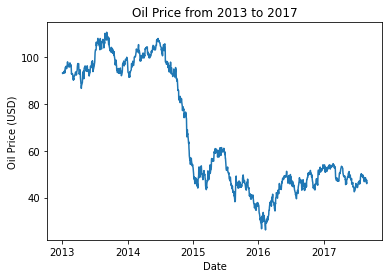

In [124]:
# Lineplot for oil vs. date
sns.lineplot(data = df_oil, x = 'date', y = 'dcoilwtico')
plt.xlabel('Date')
plt.ylabel("Oil Price (USD)")
plt.title("Oil Price from 2013 to 2017")

In [125]:
print("Table A: Analysis by day of week")
df_oil.groupby('day_of_week').describe()

Table A: Analysis by day of week


dcoilwtico                                                       \
                 count       mean        std    min     25%     50%     75%   
day_of_week                                                                   
Friday           235.0  67.856000  25.548227  29.32  46.565  53.750  95.580   
Monday           221.0  67.791222  25.746532  29.71  46.280  53.010  95.820   
Thursday         243.0  67.557160  25.630612  26.19  46.510  53.190  95.420   
Tuesday          245.0  67.767551  25.704442  27.96  46.570  53.300  95.550   
Wednesday        246.0  68.057561  25.862489  26.68  46.740  53.355  96.175   

                      year               ...                  month            \
                max  count         mean  ...     75%     max  count      mean   
day_of_week                              ...                                    
Friday       110.62  235.0  2014.846809  ...  2016.0  2017.0  235.0  6.276596   
Monday       109.62  221.0  2014.823529  ...  2016.0  2017.0  221.0  6.466063   
Thursday     108.72  243.0  2014.888889  ...  2016.0  2017.0  243.0  6.156379   
Tuesday      109.11  245.0  2014.836735  ...  2016.0  2017.0  245.0  6.306122   
Wednesday    110.17  246.0  2014.849593  ...  2016.0  2017.0  246.0  6.247967   

                                                 
                  std  min  25%  50%  75%   max  
day_of_week                                      
Friday       3.405012  1.0  3.0  6.0  9.0  12.0  
Monday       3.344599  1.0  4.0  6.0  9.0  12.0  
Thursday     3.332818  1.0  3.0  6.0  9.0  12.0  
Tuesday      3.398433  1.0  3.0  6.0  9.0  12.0  
Wednesday    3.336792  1.0  3.0  6.0  9.0  12.0  

[5 rows x 24 columns]

In [126]:
print("Table B: Analysis by type of day")
df_oil.groupby('type').describe()

Table B: Analysis by type of day


dcoilwtico                                                         \
                count       mean        std    min      25%     50%      75%   
type                                                                           
Additional       24.0  63.546667  25.119146  34.55  47.3800  54.020  97.3975   
Bridge            3.0  50.460000   5.612335  44.07  48.3950  52.720  53.6550   
Event            34.0  58.128824  25.391724  39.74  43.2475  45.475  61.3850   
Holiday         114.0  68.357895  25.830055  27.96  46.3775  54.645  96.5700   
No Holiday     1008.0  68.264375  25.665978  26.19  46.7800  53.435  95.7850   
Transfer          7.0  61.921429  22.569455  44.47  49.0850  49.580  69.5300   

                      year               ...                    month  \
               max   count         mean  ...      75%     max   count   
type                                     ...                            
Additional  105.41    24.0  2014.541667  ...  2015.25  2017.0    24.0   
Bridge       54.59     3.0  2015.000000  ...  2015.50  2016.0     3.0   
Event       107.95    34.0  2015.411765  ...  2016.00  2016.0    34.0   
Holiday     107.43   114.0  2014.789474  ...  2016.00  2017.0   114.0   
No Holiday  110.62  1008.0  2014.838294  ...  2016.00  2017.0  1008.0   
Transfer    102.17     7.0  2015.714286  ...  2017.00  2017.0     7.0   

                                                               
                 mean       std  min   25%   50%    75%   max  
type                                                           
Additional  11.166667  1.903467  7.0  12.0  12.0  12.00  12.0  
Bridge       8.000000  6.082763  1.0   6.0  11.0  11.50  12.0  
Event        6.088235  2.550908  4.0   4.0   5.0   6.75  12.0  
Holiday      7.245614  3.064387  2.0   5.0   7.0  10.75  12.0  
No Holiday   6.058532  3.335814  1.0   3.0   6.0   9.00  12.0  
Transfer     7.142857  2.478479  4.0   5.0   8.0   9.00  10.0  

[6 rows x 24 columns]

In [127]:
print("Table C: Analysis by month")
df_oil.groupby('month').describe()

Table C: Analysis by month


dcoilwtico                                                          \
           count       mean        std    min      25%     50%       75%   
month                                                                      
1          101.0  65.082079  26.061052  26.68  45.9300  52.720   93.6600   
2           96.0  65.727708  27.640318  26.19  49.1375  53.555   96.6825   
3          108.0  64.706759  25.884008  34.39  45.7200  49.720   93.4300   
4          105.0  68.386857  24.662380  34.30  49.2200  55.710   94.0900   
5          107.0  70.133738  23.722713  43.45  48.2900  59.230   95.6350   
6          114.0  71.495877  25.158963  42.48  48.3625  59.925   96.9150   
7          107.0  71.843178  28.297737  41.13  46.4650  52.190  103.9500   
8          110.0  67.323545  27.943270  38.22  45.1600  48.465   97.5175   
9           83.0  72.134217  27.731482  43.04  45.2850  47.720   95.5250   
10          89.0  70.963034  23.277731  43.19  48.7200  80.530   96.2900   
11          80.0  64.062875  21.689055  39.27  44.6500  48.740   82.0900   
12          90.0  60.688778  22.206253  34.55  43.2725  53.775   67.2225   

                year                                                          \
          max  count         mean       std     min      25%     50%     75%   
month                                                                          
1       98.25  101.0  2014.960396  1.427731  2013.0  2014.00  2015.0  2016.0   
2      103.46   96.0  2015.010417  1.417892  2013.0  2014.00  2015.0  2016.0   
3      105.34  108.0  2015.064815  1.416018  2013.0  2014.00  2015.0  2016.0   
4      104.35  105.0  2014.952381  1.409998  2013.0  2014.00  2015.0  2016.0   
5      105.01  107.0  2015.009346  1.437341  2013.0  2014.00  2015.0  2016.0   
6      107.95  114.0  2014.982456  1.401532  2013.0  2014.00  2015.0  2016.0   
7      108.00  107.0  2014.897196  1.407088  2013.0  2014.00  2015.0  2016.0   
8      110.17  110.0  2015.036364  1.433078  2013.0  2014.00  2015.0  2016.0   
9      110.62   83.0  2014.518072  1.119249  2013.0  2014.00  2015.0  2015.5   
10     104.15   89.0  2014.460674  1.118605  2013.0  2013.00  2014.0  2015.0   
11      95.35   80.0  2014.525000  1.136005  2013.0  2013.75  2015.0  2016.0   
12      99.94   90.0  2014.511111  1.104073  2013.0  2014.00  2014.5  2015.0   

               
          max  
month          
1      2017.0  
2      2017.0  
3      2017.0  
4      2017.0  
5      2017.0  
6      2017.0  
7      2017.0  
8      2017.0  
9      2016.0  
10     2016.0  
11     2016.0  
12     2016.0

In [128]:
print("Table C: Analysis by year")
df_oil.groupby('year').describe()

Table C: Analysis by year


dcoilwtico                                                               \
          count       mean        std    min     25%    50%      75%     max   
year                                                                           
2013      255.0  97.976549   5.440222  86.65  93.780  96.29  102.945  110.62   
2014      258.0  93.081860  13.904969  53.45  90.810  97.86  102.815  107.95   
2015      255.0  48.693294   6.901144  34.55  44.465  47.88   52.875   61.36   
2016      255.0  43.340392   6.725287  26.19  39.620  45.20   48.385   54.01   
2017      167.0  49.232874   3.039884  42.48  47.045  48.96   52.345   54.48   

      month                                                 
      count      mean       std  min  25%  50%   75%   max  
year                                                        
2013  255.0  6.541176  3.413335  1.0  4.0  7.0   9.5  12.0  
2014  258.0  6.589147  3.437292  1.0  4.0  7.0  10.0  12.0  
2015  255.0  6.584314  3.433243  1.0  4.0  7.0  10.0  12.0  
2016  255.0  6.560784  3.423407  1.0  4.0  7.0   9.5  12.0  
2017  167.0  4.562874  2.296002  1.0  3.0  5.0   6.5   8.0

**Observations**
- We note that the oil prices have dropped significantly from 2013 to late 2017. In Table C, the mean dropped from USD 90 to USD 50. This was mainly due to the economic indicators during the year
- We also see that the mean of the oil prices have remained consistent across the week days
- The mean price by month is also consistent. We see that oil price ranges from 60 - 70 in most months with consistent deviation across the months.

#### Stores Dataset

*Work Done*
- The stores dataset comprises of 54 different stores spread across cities / states
- We have added a new column which shows the total transactions by store

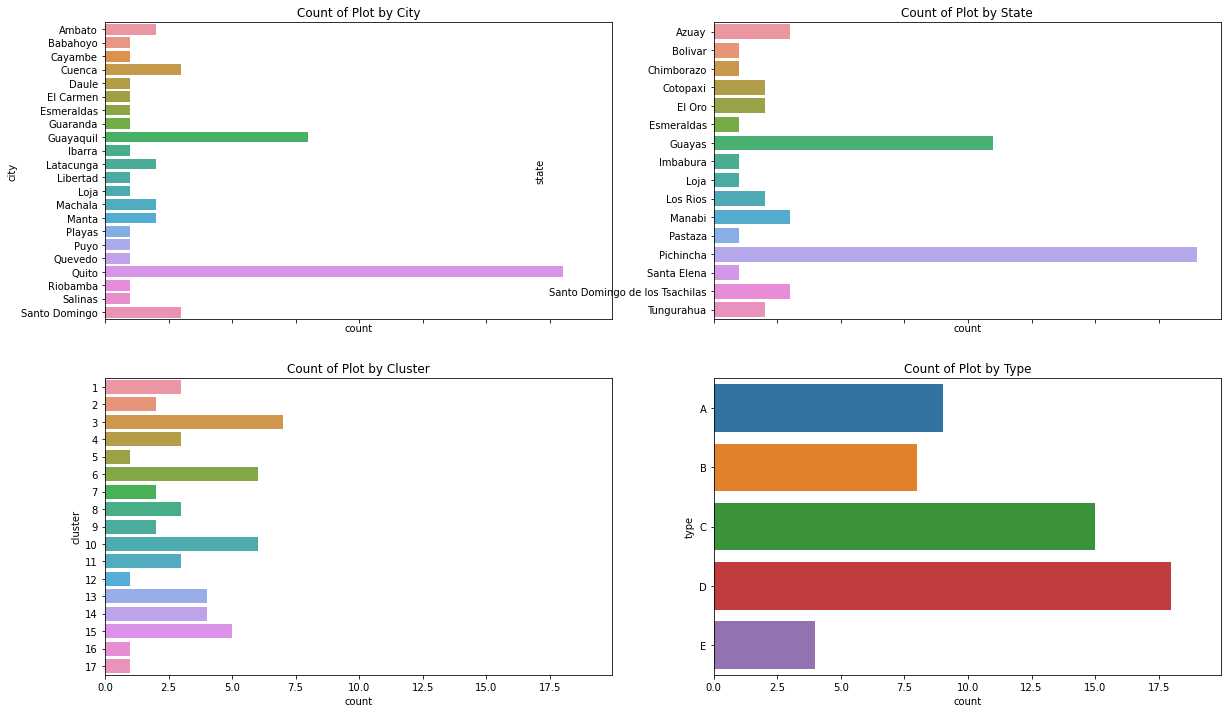

In [129]:
# Subplot for count of stores by city, state, cluster and type
f, axes = plt.subplots(2,2, figsize = (20,12), sharex = True)
k1 = sns.countplot(data = df_stores.sort_values('city', ascending = True), y = 'city', ax = axes[0,0]).set(title = 'Count of Plot by City')
k2 = sns.countplot(data = df_stores.sort_values('state', ascending = True), y = 'state', ax = axes[0,1]).set(title = 'Count of Plot by State')
k3 = sns.countplot(data = df_stores.sort_values('cluster', ascending = True), y = 'cluster', ax = axes[1,0]).set(title = 'Count of Plot by Cluster')
k4 = sns.countplot(data = df_stores.sort_values('type', ascending = True), y = 'type', ax = axes[1,1]).set(title = 'Count of Plot by Type')

In [130]:
# Count of transactions by store number
count_transactions_df = df_transactions.groupby('store_nbr').count()
count_transactions_df= count_transactions_df.reset_index()
# Put count of transactions by store into the store dataset
df_stores = pd.merge(left = df_stores, right = count_transactions_df, how = 'inner',
                     on = 'store_nbr')
# Delete the date column from the dataset
df_stores.drop('date', axis = 1, inplace = True)
# Convert cluster to string for barplot
df_stores['cluster'] = df_stores['cluster'].apply(str)

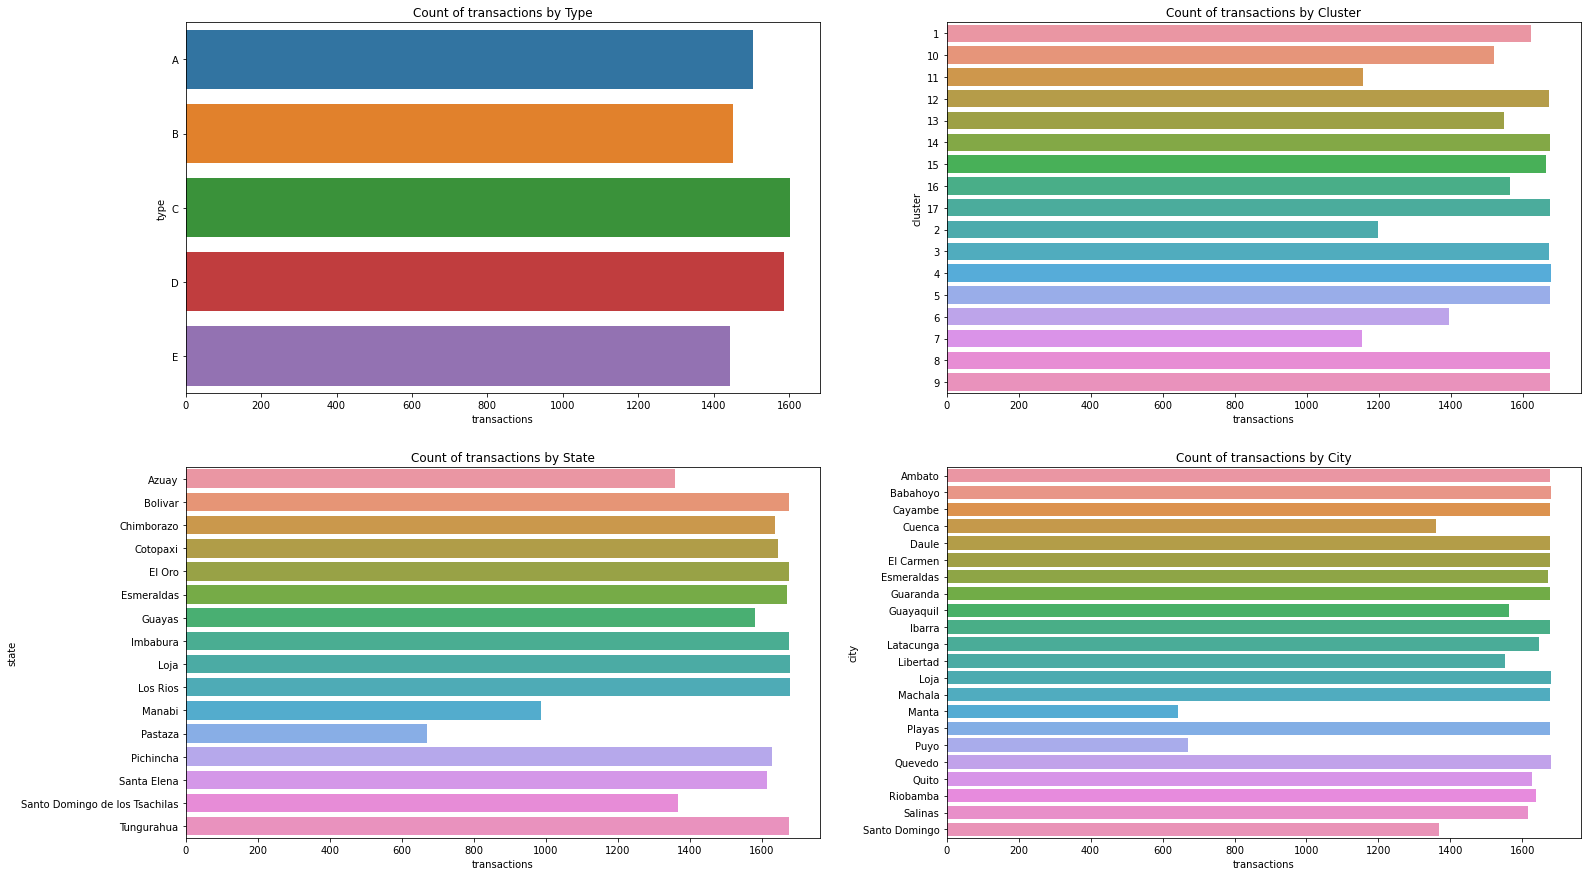

In [131]:
# Subplot for count of stores by city, state, cluster and type
f, axes = plt.subplots(2,2, figsize = (25,15))
f1 = sns.barplot(data = df_stores.sort_values('type',ascending = True), x = 'transactions', y = 'type', ci = None, ax = axes[0,0]).set(title = 'Count of transactions by Type')
f2 = sns.barplot(data = df_stores.sort_values('cluster',ascending = True), x = 'transactions', y = 'cluster', ci = None, ax = axes[0,1]).set(title = 'Count of transactions by Cluster')
f3 = sns.barplot(data = df_stores.sort_values('state',ascending = True), x = 'transactions', y = 'state', ci = None, ax = axes[1,0]).set(title = 'Count of transactions by State')
f4 = sns.barplot(data = df_stores.sort_values('city',ascending = True), x = 'transactions', y = 'city', ci = None, ax = axes[1,1]).set(title = 'Count of transactions by City')

In [132]:
df_stores.groupby(['state','city']).describe()

store_nbr                        \
                                                 count       mean        std   
state                          city                                            
Azuay                          Cuenca              3.0  39.333333   2.516611   
Bolivar                        Guaranda            1.0  19.000000        NaN   
Chimborazo                     Riobamba            1.0  14.000000        NaN   
Cotopaxi                       Latacunga           2.0  12.500000   0.707107   
El Oro                         Machala             2.0  40.500000   0.707107   
Esmeraldas                     Esmeraldas          1.0  43.000000        NaN   
Guayas                         Daule               1.0  27.000000        NaN   
                               Guayaquil           8.0  31.750000   8.396428   
                               Libertad            1.0  36.000000        NaN   
                               Playas              1.0  35.000000        NaN   
Imbabura                       Ibarra              1.0  15.000000        NaN   
Loja                           Loja                1.0  38.000000        NaN   
Los Rios                       Babahoyo            1.0  31.000000        NaN   
                               Quevedo             1.0  33.000000        NaN   
Manabi                         El Carmen           1.0  54.000000        NaN   
                               Manta               2.0  52.500000   0.707107   
Pastaza                        Puyo                1.0  22.000000        NaN   
Pichincha                      Cayambe             1.0  11.000000        NaN   
                               Quito              18.0  21.333333  19.054103   
Santa Elena                    Salinas             1.0  25.000000        NaN   
Santo Domingo de los Tsachilas Santo Domingo       3.0  14.000000   8.185353   
Tungurahua                     Ambato              2.0  36.500000  19.091883   

                                                                              \
                                               min    25%   50%    75%   max   
state                          city                                            
Azuay                          Cuenca         37.0  38.00  39.0  40.50  42.0   
Bolivar                        Guaranda       19.0  19.00  19.0  19.00  19.0   
Chimborazo                     Riobamba       14.0  14.00  14.0  14.00  14.0   
Cotopaxi                       Latacunga      12.0  12.25  12.5  12.75  13.0   
El Oro                         Machala        40.0  40.25  40.5  40.75  41.0   
Esmeraldas                     Esmeraldas     43.0  43.00  43.0  43.00  43.0   
Guayas                         Daule          27.0  27.00  27.0  27.00  27.0   
                               Guayaquil      24.0  27.50  29.5  32.50  51.0   
                               Libertad       36.0  36.00  36.0  36.00  36.0   
                               Playas         35.0  35.00  35.0  35.00  35.0   
Imbabura                       Ibarra         15.0  15.00  15.0  15.00  15.0   
Loja                           Loja           38.0  38.00  38.0  38.00  38.0   
Los Rios                       Babahoyo       31.0  31.00  31.0  31.00  31.0   
                               Quevedo        33.0  33.00  33.0  33.00  33.0   
Manabi                         El Carmen      54.0  54.00  54.0  54.00  54.0   
                               Manta          52.0  52.25  52.5  52.75  53.0   
Pastaza                        Puyo           22.0  22.00  22.0  22.00  22.0   
Pichincha                      Cayambe        11.0  11.00  11.0  11.00  11.0   
                               Quito           1.0   6.25  13.5  44.75  49.0   
Santa Elena                    Salinas        25.0  25.00  25.0  25.00  25.0   
Santo Domingo de los Tsachilas Santo Domingo   5.0  10.50  16.0  18.50  21.0   
Tungurahua                     Ambato         23.0  29.75  36.5  43.25  50.0   

                                           

**Observations**
- We note that the city "Quito has the highest number of stores. The state of Pichnicha has the highest number of stores. The third cluster has the highest number of stores. Type D stores are the most prevalent nationally.
- We also note that the numbr of transactions are quite uniform across teh different types of stores. However, we note that the states of Manabi and Pastaza have the lowest number of transactions. This is also noted in the cities of Manta and Puyo which both have a low number of transactions.
- We note that the state with the most stores is Pichincha. This is mainly due to the concentration of 18 stores in Quito.
- However, in terms of the number of transactions, Guayas has the highest number of transactions. The total transactions spread across 4 cities (11 stores) in Guayas is 6,465. In comparison Pichincha, the state with the highest number of stores has 3,303

**Transactions Dataset**

*Work Done*
- There are 83,488 transactions
- We have aggregated the transactions by month and year
- We have also mapped the oil prices to the transaction by day

In [133]:
# Convert string date to timestamp date
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
# Obtain month of transaction
df_transactions['month'] = df_transactions['date'].dt.month
# Obtain year of transaction
df_transactions['year'] = df_transactions['date'].dt.year
# Day of week
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek
df_transactions['day_of_week'] = convert_to_day(df_transactions['day_of_week'])

In [134]:
# Unique years from df transactions
year_list = list(df_transactions['year'].unique())
# Unique day of week from df transactions
day_of_week_list = list(df_transactions['day_of_week'].unique())
# Unique months from df transactions
months_list = list(df_transactions['month'].unique())

In [135]:
# Create a summary of transactions (mean, median, total) by year, month and day of week
df_transactions_summary = pd.DataFrame(columns = ['year','month','day_of_week','mean_transaction','median_transaction','total_transaction'])

# filter and summarize df_transaction by year, month and day of week
for i in range(len(year_list)):
    for k in range(len(months_list)):
        for j in range(len(day_of_week_list)):
            mean = df_transactions[(df_transactions['day_of_week'] == day_of_week_list[j]) & (df_transactions['month'] == months_list[k]) & (df_transactions['year'] == year_list[i])]['transactions'].mean()
            median = df_transactions[(df_transactions['day_of_week'] == day_of_week_list[j]) & (df_transactions['month'] == months_list[k]) & (df_transactions['year'] == year_list[i])]['transactions'].median()
            total_transaction = df_transactions[(df_transactions['day_of_week'] == day_of_week_list[j]) & (df_transactions['month'] == months_list[k]) & (df_transactions['year'] == year_list[i])]['transactions'].sum()
            df_transactions_summary = df_transactions_summary.append({'year':year_list[i],'month':months_list[k],'day_of_week':day_of_week_list[j],'mean_transaction':mean,'median_transaction':median,'total_transaction':total_transaction},ignore_index=True)

# In 2017, there were no transactions from September onwards. We have to remove these NA values from the summary dataframe
len(df_transactions_summary[df_transactions_summary['mean_transaction'].isna()]) # Based on this there are 28 na values which will be removed
df_transactions_summary = df_transactions_summary.dropna()

In [136]:
# Convert the date to datetime for df holidays dataset
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
# Combine the df_transactions and df_holidays_events datasets
df_transactions = pd.merge(df_transactions,df_holidays_events ,on = 'date', how = 'outer')
# Remove extra NA values from the dataset (based on store_nbr since that is from the original dataset)
df_transactions = df_transactions[df_transactions['store_nbr'].notna()]
# Remove unnecessary columns from the df_holidays dataset
df_transactions = df_transactions.drop(['locale','locale_name','description','transferred'], axis = 1)

In [137]:
# Combine the df_transactions and df_oil dataset
df_transactions = pd.merge(df_transactions,df_oil, on = 'date', how = 'outer')
# Remove extra NA values from the dataset (based on store_nbr since that is from the original dataset)
df_transactions = df_transactions[df_transactions['store_nbr'].notna()]
# Remove unnecessary columns
df_transactions = df_transactions.drop(['day_of_week_y','type_y','year_y','month_y'],axis = 1)
# Change NA values in type column to "No Holiday"
df_transactions['type_x'].fillna('No Holiday',inplace = True)
# Sort values of the dataset by date
df_transactions = df_transactions.sort_values('date',ascending = True)
# Reset index
df_transactions = df_transactions.reset_index()
df_transactions.drop('index',axis = 1, inplace = True)

In [138]:
df_transactions.isna().sum()

date                 0
store_nbr            0
transactions         0
month_x              0
year_x               0
day_of_week_x        0
type_x               0
dcoilwtico       26422
dtype: int64

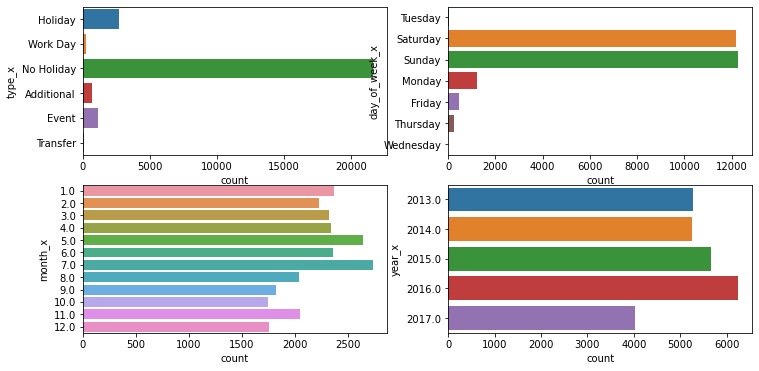

In [139]:
f, axes = plt.subplots(2,2, figsize = (12,6))
k1 = sns.countplot(data = df_transactions[df_transactions['dcoilwtico'].isna()], y = 'type_x', ax = axes[0,0])
k2 = sns.countplot(data = df_transactions[df_transactions['dcoilwtico'].isna()], y = 'day_of_week_x', ax = axes[0,1])
k3 = sns.countplot(data = df_transactions[df_transactions['dcoilwtico'].isna()], y = 'year_x', ax = axes[1,1])
k4 = sns.countplot(data = df_transactions[df_transactions['dcoilwtico'].isna()], y = 'month_x', ax = axes[1,0])

We note that the majority of the NA values in 'dcoilwtico' are for Saturday and Sunday due to these 2 days being holidays. This is consistent across the years. Weekdays are holidays that have occured during the year. 

*Approach: We will get the closest oil price before the date and input that as the date for the NA values*

In [159]:
# list that shows the NA values for oil price
list1 = df_transactions['dcoilwtico'].isna()
# As 2013-01-01 had a NA value. We used the second oil price of $93.14
oil_price = 93.14
# The function uses the last non-NA oil price and puts that into the future NA values until the next value is identified.
for i in range(len(df_transactions)):
    if (list1[i] == False):
        oil_price = df_transactions['dcoilwtico'][i] 
        
    elif (list1[i] == True):
        df_transactions['dcoilwtico'][i] = oil_price

<ipython-input-159-6b7906fff40b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions['dcoilwtico'][i] = oil_price


<AxesSubplot:xlabel='dcoilwtico', ylabel='transactions'>

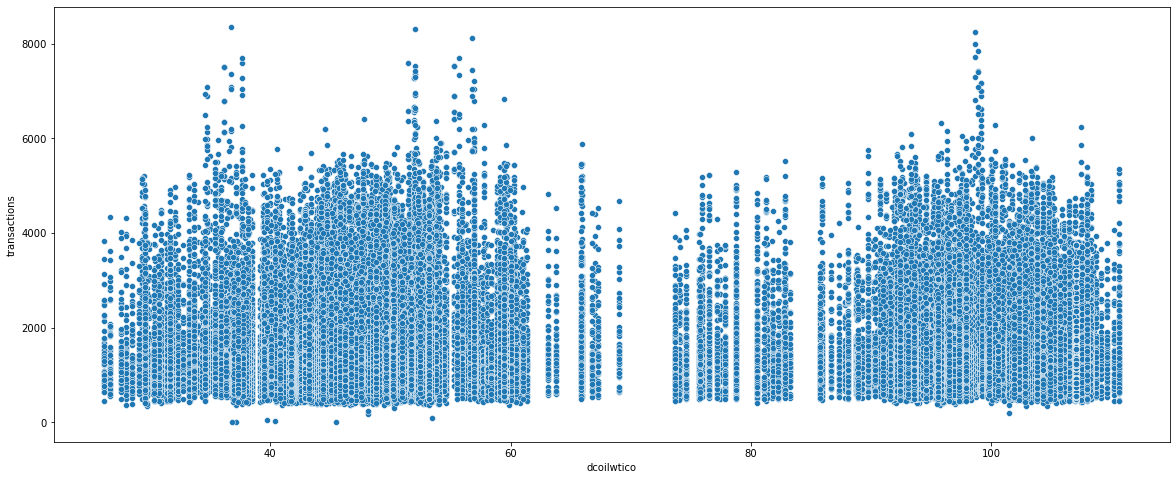

In [177]:
plt.figure(figsize = (20,8))
sns.scatterplot(data = df_transactions,x = 'dcoilwtico', y = 'transactions')